<a href="https://colab.research.google.com/github/paruliansaragi/Lessons-from-fast.ai/blob/master/Fastai2019L8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matmul

### imports data load

In [0]:
!pip install fastai

In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [0]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))# map takes function and does that to all elements of array
# in this case apply torch tensor to each 
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
assert n==y_train.shape[0]==50000

In [0]:
mpl.rcParams['image.cmap'] = 'gray' 

In [0]:
img = x_train[0]
img.view(28,28).type()

'torch.FloatTensor'

In [0]:
img.shape

torch.Size([784])

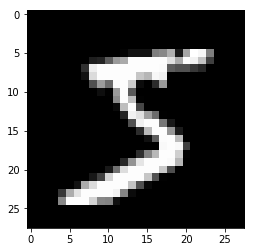

In [0]:
plt.imshow(img.view((28,28))) # .view reshapes 
#in this case reshape 784 long vector into 28x28

### Initial Python Model

In [0]:
weights = torch.randn(784, 10)#random init
bias = torch.zeros(10)

### Mat mul loops Python

- example of mat mul from scratch

In [0]:
def matmul(a,b):
  rows, cols = a.shape
  brows, bcols = b.shape
  assert cols==brows
  c = torch.zeros(rows, bcols)
  for i in range(rows): #for each rows
    for j in range(bcols): #for each bcol in each row
      for k in range(cols): #for each element in col in each bcol in each row do multiplication and summation
        c[i,j] += a[i,k] * b[k,j]
  return c

In [0]:
m1 = x_valid[:5]
m2 = weights

In [0]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [0]:
%time t1=matmul(m1, m2)

CPU times: user 718 ms, sys: 0 ns, total: 718 ms
Wall time: 720 ms


In [0]:
t1.shape

torch.Size([5, 10])

In [0]:
t1

tensor([[  1.3030, -16.7730,   7.1580,  -5.9198,   7.0124,   8.4855,  -0.2477,
           7.2836,  -2.9298, -17.9405],
        [  1.6914,  -5.8262,  19.0501,   2.6722,   0.7795,  -3.2849,  -9.0679,
          12.0541,  -2.5347, -29.4379],
        [  1.4314,  -6.3727,  -1.2675,  12.6470,  10.1448,   0.6885,  -6.4634,
           6.6194,   5.3929,   6.1812],
        [  1.5566,  -7.8667, -19.5515, -16.5700,   6.7333,   0.2652,  -9.8393,
           7.5904,   0.5260, -13.2597],
        [  7.3145, -14.9225, -11.1600,   9.2615,   8.9004,  -1.5887,  -4.1688,
           5.5148,   2.2683,  -5.4907]])

### Elementwise Ops

In [0]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [0]:
a+b

tensor([12., 14.,  3.])

In [0]:
(a<b).float().mean()

tensor(0.6667)

Frobenius Norm:

$||A||_F = (\sum^{n}_{i,j=1}|a_{ij}|^2)^{1/2}$


In [0]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]);m
(m*m).sum().sqrt() # equivalent to the above frobenius norm equation
# sum over two for loops called i from 1 to n, and loop over j from 1 to n, 
#then grab something out of matrix 'a' at position i,j squared then sum all those
#and take the square root

tensor(16.8819)

#### Elementwise matmul

In [0]:
#that means we can replace the loop in the above mat mul
def matmul(a,b):
  rows, cols = a.shape
  brows, bcols = b.shape
  assert cols==brows
  c = torch.zeros(rows, bcols)
  for i in range(rows): # a[i, :] =  for each row [1,2,3]
    for j in range(bcols): # b[:, j] = for each col [1,
                                          #2,
                                          #3]
      c[i,j] = (a[i,:] * b[:,j]).sum()#
  return c

In [0]:
%timeit -n 10 _=matmul(m1,m2)

10 loops, best of 3: 1.18 ms per loop


### Broadcasting

- broadcast something across all elements. It describes how arrays with different shapes are treated during arithmetic operations.
- describes how numpy treats arrays with different shapes during arithmetic operations. The smaller array is broadcast across the larger so they have compatible shapes. Means of vectorizing array operations so looping occurs in C not python. Doing so without needless copies of data.
- gets rid of loops at C or cuda speed

In [0]:
#bc with scalar
a

tensor([10.,  6., -4.])

In [0]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

How does this work? The value of 0 is broadcast three times then does elemtwise operation. You broadcast a scalar to a tensor here.

#### Broadcasting a vector to a matrix

In [0]:
c = tensor([1.,2,3])

In [0]:
m + c #it broadcast the row across all of m

tensor([[ 2.,  4.,  6.],
        [ 5.,  7.,  9.],
        [ 8., 10., 12.]])

In [0]:
t = c.expand_as(m)

In [0]:
t

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])

In [0]:
m + t

tensor([[ 2.,  4.,  6.],
        [ 5.,  7.,  9.],
        [ 8., 10., 12.]])

In [0]:
t.stride()

(0, 1)

In [0]:
c.unsqueeze(0), c.unsqueeze(0).shape

(tensor([[1., 2., 3.]]), torch.Size([1, 3]))

In [0]:
c.unsqueeze(1), c.unsqueeze(1).shape # looks like a column

(tensor([[1.],
         [2.],
         [3.]]), torch.Size([3, 1]))

In [0]:
c[None, :], c[None, :].shape # squeeze a new axis here please

(tensor([[1., 2., 3.]]), torch.Size([1, 3]))

In [0]:
c[:, None], c[:, None].shape # squeeze a new axis here please
#same as unsqueeze( axis )

(tensor([[1.],
         [2.],
         [3.]]), torch.Size([3, 1]))

In [0]:
c[None].shape, c[..., None].shape # "..." 

(torch.Size([1, 3]), torch.Size([3, 1]))

In [0]:
c[:, None].expand_as(m)

tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.]])

In [0]:
m + c[:, None]

tensor([[ 2.,  3.,  4.],
        [ 6.,  7.,  8.],
        [10., 11., 12.]])

### Matmul with broadcasting

In [0]:
#that means we can replace the loop in the above mat mul
def matmul(a,b):
  rows, cols = a.shape
  brows, bcols = b.shape
  assert cols==brows
  c = torch.zeros(rows, bcols)
  for i in range(rows):
    c[i] = (a[i  ].unsqueeze(-1) * b).sum(dim=0)
  return c

In [0]:
%timeit -n 10 _=matmul(m1,m2)

10 loops, best of 3: 262 µs per loop


### Einstein Summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. The subscript strings in comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeat it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i'm a)` produces a view of a with no changes.

In [0]:
# einstein summation notation inside a string. left of arrow is input right is input delimeted by comma, rank of input given by however many letters
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [0]:
%timeit -n 10 _=matmul(m1,m2)

The slowest run took 101.10 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 33.1 µs per loop


### pytorch op matmul

In [0]:
%timeit -n 10 t2= m1.matmul(m2)
#50,000X faster than python
#matmul doesn't fit in cache and you forget the contents of what we originally operated and we go to ram to get it again
#matmul makes mini matrices of the matrix.
# Pytorch doesn't even do this itself it uses blas = Basic Linear Algebra Sub-programme
# where Intel, AMD, NVidia write this for you e.g. Cublas or BKL
# program is limited by what your blas can handle and you dont write it in python.
# tensor comprehensions : in pytorch, ways to compile these things.

The slowest run took 97.42 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 5.78 µs per loop


In [0]:
%timeit -n 10 t2= m1@m2 # not just matmul but same speed since it calls same thing

The slowest run took 18.93 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 5.92 µs per loop


# Relu

In [0]:
def get_data():
  path = datasets.download_data(MNIST_URL, ext='.gz')
  with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
  return map(tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
def normalize(x, m, s): return (x-m)/s

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
train_mean,train_std = x_train.mean(), x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [0]:
x_train = normalize(x_train, train_mean, train_std)
# normalise both in same way
x_valid = normalize(x_valid, train_mean, train_std)

In [0]:
train_mean,train_std = x_train.mean(), x_train.std()
train_mean,train_std

(tensor(0.0001), tensor(1.))

In [0]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

## Foundations version
### Basic Architecture

- Model with 1 hidden layer

In [0]:
#num hidden
nh = 50

In [0]:
# simple kaiming init / he init
# mean 0 std 1
# if we dont the std and mean of our linear layer we get really bad mean and std
w1 = torch.randn(m, nh)/math.sqrt(m)
#w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)/math.sqrt(nh)
#w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

In [0]:
w1.mean()

tensor(0.0002)

In [0]:
x_valid.mean(), x_valid.std()

(tensor(-0.0057), tensor(0.9924))

In [0]:
def linear_layer(x, w, b): return x@w + b

In [0]:
t = linear_layer(x_valid, w1, b1)

In [0]:
t.mean(), t.std()

(tensor(-0.0316), tensor(0.9906))

In [0]:
def relu(x): return x.clamp_min(0.)

In [0]:
t = relu(linear_layer(x_valid, w1, b1))

In [0]:
t.mean(), t.std()

(tensor(0.3758), tensor(0.5824))

- This doesn't give mean 0 and std 1. From pytorch docs: `a: the negative slope of the rectifier user after this layer (0 for ReLU by default)`

$std = \sqrt{ \frac{2}{(1+a^2) * fanin} }$

This was introducted in the paper that described the Imagenet-winning approach from *He et al: Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*. 

- Initialization of Filter Weights for Rectifiers : people used to initialize with random Gaussian distributions and led to poor training. Glorot and Bengio (Xavier initialization) : They describe one way to initialize is:

$\frac{\sqrt{6}}{\sqrt{numinputfilters + numoutputerfilters}}$

We took everything smaller than 0 and removed it so it has half the std and not mean 0. 

All the paper does is does $2/m$ 

In [0]:
# kaiming init/ he init for relu
w1 = torch.randn(m, nh)*math.sqrt(2/m)
w1.mean(), w1.std()

(tensor(2.6480e-05), tensor(0.0504))

In [0]:
t = relu(linear_layer(x_valid, w1, b1))

In [0]:
t.mean(), t.std()
#it gives a bad mean since we deleted everything below 0 
#jeremy has tried using x.clamp_min(0.) - 0.5 and it seems to help

(tensor(0.4307), tensor(0.7205))

In [0]:
from torch.nn import init

In [0]:
w1 = torch.zeros(m,nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(linear_layer(x_valid, w1, b1))

In [0]:
t.mean(), t.std()

(tensor(0.5255), tensor(0.8205))

In [0]:
??init.kaiming_normal_()

In [0]:
w1.shape

torch.Size([784, 50])

In [0]:
import torch.nn

In [0]:
torch.nn.Linear(m, nh).weight.shape

torch.Size([50, 784])

In [0]:
torch.nn.functional.linear??

In [0]:
torch.nn.Conv2d??

In [0]:
torch.nn.modules.conv._ConvNd.reset_parameters??

In [0]:
def relu(x): return x.clamp_min(0.) - 0.5

In [0]:
# kaiming init/ he init for relu
w1 = torch.randn(m, nh)*math.sqrt(2./m)
t1 = relu(linear_layer(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.5255), tensor(0.8205))

In [0]:
def model(xb):
  l1 = linear_layer(xb, w1, b1)
  l2 = relu(l1)
  l3 = linear_layer(l2, w2, b2)
  return l3

In [0]:
%timeit -n 10 _=model(x_valid)

### Loss function: MSE

In [0]:
model(x_valid).shape

torch.Size([10000, 50])

In [0]:
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [0]:
y_train, y_valid=y_train.float(),y_valid.float()

In [0]:
preds = model(x_train)

In [0]:
preds.shape

torch.Size([50000, 1])

In [0]:
mse(preds, y_train)

tensor(26.5780)

### That's a forward pass
### Gradients and backward pass

We do need to know matrix calculus and the chain rule. 

- we want the gradient w.r.t parameters.

$dy/dx= dy/du * du/dx$

You can just cross multiply and you can just get $dy/dx$.

In [0]:
def mse_grad(inp, targ):
  # gradient of loss w.r.t output of prev layer
  # mse is just input - targ squared so the gradient is just 2 * input-target because the derivative of something^2 is just 2 * something
  inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [0]:
def relu_grad(inp, out):
  #grad of relu w.r.t input activations
  # it is just the input greater than 1 but because of the chain rule, so we need to multiply this with the gradient of the next layer
  inp.g = (inp>0).float() * out.g

In [0]:
def lin_grad(inp, out, w, b):
  # grad of matmul w.r.t input
  # the gradient of a matrix product is simply, the matrix product with the transpose
  inp.g = out.g @ w.t()
  w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
  b.g = out.g.sum(0)

This function does both. It calls each gradient backwards in reverse order for chain rule. Each time we pass in the result of the forward pass, and it has access to the gradient of the next layer ~> this is backpropagation. It is the chain rule where we save the intermediate calculations and don't have to calculate them again. 

In [0]:
def forward_and_backward(inp, targ):
  #forward pass:
  l1 = inp @ w1 + b1
  l2 = relu(l1)
  out = l2 @ w2 + b2
  #we dont actually need loss in backward!
  loss = mse(out, targ)
  
  #backward
  mse_grad(out, targ)
  lin_grad(l2, out, w2, b2)
  relu_grad(l1, l2)
  lin_grad(inp, l1, w1, b1)

In [0]:
forward_and_backward(x_train, y_train)

In [0]:
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig = x_train.g.clone()

Let's use autograd to check the results.

In [0]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)
#turns tensor into and keeps track of (operations) forward pass to do gradient

In [0]:
def forward(inp, targ):
  l1 = inp@w12 + b12
  l2 = relu(l1)
  out = l2@ w22 + b2
  return mse(out, targ)

In [0]:
loss = forward(xt2, y_train)

In [0]:
loss.backward()

### Layers as Classes

In [0]:
class Relu():
  def __call__(self, inp):
    #dunder call means we can call this class as a function
    self.inp = inp
    self.out = inp.clamp_min(0.)-0.5
    return self.out
  
  def backward(self): self.inp.g = (self.inp>0).float() * self.out.g
    #same as before and we store self.inp.g

In [0]:
class Lin():
  def __init__(self, w, b): self.w, self.b = w,b
  
  def __call__(self,inp):
    self.inp = inp
    self.out = inp@self.w + self.b
    return self.out
  
  def backward(self):
    self.inp.g = self.out.g @ self.w.t()
    #creating giant outer product, just to sum it, is inefficient!
    self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
    self.b.g = self.out.g.sum(0)

In [0]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [0]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [0]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [0]:
%time loss = model(x_train, y_train)

CPU times: user 127 ms, sys: 0 ns, total: 127 ms
Wall time: 127 ms


In [0]:
%time model.backward()

CPU times: user 3.25 s, sys: 4.13 s, total: 7.38 s
Wall time: 7.39 s


### Module.forward()

In [0]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [0]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [0]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [0]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [0]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [0]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [0]:
%time loss = model(x_train, y_train)

CPU times: user 93.7 ms, sys: 5.89 ms, total: 99.6 ms
Wall time: 103 ms


In [0]:
%time model.backward()

CPU times: user 220 ms, sys: 114 ms, total: 333 ms
Wall time: 348 ms


In [0]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [0]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [0]:
%time loss = model(x_train, y_train)

CPU times: user 123 ms, sys: 1.38 ms, total: 125 ms
Wall time: 130 ms


In [0]:
%time model.backward()

CPU times: user 242 ms, sys: 5.45 ms, total: 248 ms
Wall time: 251 ms


In [0]:
from torch import nn

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(), targ)

In [0]:
model = Model(m, nh, 1)

In [0]:
%time loss = model(x_train, y_train)

CPU times: user 89.5 ms, sys: 2.06 ms, total: 91.6 ms
Wall time: 99.5 ms


In [0]:
%time loss.backward()

CPU times: user 80.1 ms, sys: 792 µs, total: 80.9 ms
Wall time: 85.4 ms
